## Which are organizations or political figures do they tweet about?  What sentiments do they demonstrate when discussing these entities?
### Named entity recognition and sentiment analysis

In [1]:
import os
import re
import numpy as np
import random
import spacy
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from spacy import displacy
from collections import Counter
import en_core_web_md
nlp = en_core_web_md.load()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
eng_tweets = pd.read_pickle('../data/eng_tweets.p')

In [3]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub(r'"''~',"",str(x)))

In [4]:
eng_tweets.content.head()

0    We have a sitting Democrat US Senator on trial...
1    Marshawn Lynch arrives to game in anti Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN President Trump dedicates Presidents C...
4    19000 RESPECTING our National Anthem Stand For...
Name: content, dtype: object

In [5]:
targets = ['RightTroll', 'LeftTroll', 'NewsFeed']
subset = eng_tweets.loc[eng_tweets.account_category.isin(targets)]

In [6]:
#if os.path.exists('../data/eng_tweets_with_entities.csv'):
#    subset = pd.read_csv('../data/eng_tweets_with_entities.csv', 
#                         converters={"entities": lambda x: x.strip("[]").split(", "), 
#                                     "labels": lambda x: x.strip("[]").split(", ")})
#else:

subset['docs'] = subset.content.apply(nlp)

In [7]:
subset['entities'] = subset.docs.apply(lambda doc: [ent.text for ent in doc.ents])
subset['labels'] = subset.docs.apply(lambda doc: [ent.label_ for ent in doc.ents])
subset['sentences'] = subset.docs.apply(lambda doc: [sent for sent in doc.sents])

In [8]:
flattened_entities = subset.entities.tolist()
flattened_entities = pd.Series([str(item) for sublist in flattened_entities for item in sublist])
#flattened_entities = flattened_entities.loc[flattened_entities != ''].astype(str)

flattened_labels = subset.labels.tolist()
flattened_labels = pd.Series([str(item) for sublist in flattened_labels for item in sublist])
#flattened_labels = flattened_labels.loc[flattened_labels != ''].astype(str)

In [9]:
flattened_entities.loc[0:100]

0                        Democrat
1                              US
2                  Marshawn Lynch
3                           Trump
4                           Lynch
5                            Navy
6                             NFL
7                     Boycott NFL
8                           Trump
9                         Florida
10                          Texas
11                    Puerto Rico
12                          19000
13                    Dan Bongino
14                   Donald Trump
15     Menendez Carmen Yulin Cruz
16                            CNN
17                            CNN
18                          Trump
19                             PR
20                   two days ago
21                       San Juan
22                            CNN
23                       San Juan
24                            CNN
25                  Sarah Sanders
26                            NBC
27                          Trump
28                 Michelle Obama
29            

In [10]:
flattened_labels.loc[0:100]

0          NORP
1           GPE
2        PERSON
3           ORG
4           ORG
5           ORG
6           ORG
7           ORG
8        PERSON
9           GPE
10          GPE
11          GPE
12     CARDINAL
13       PERSON
14       PERSON
15       PERSON
16          ORG
17          ORG
18          ORG
19          ORG
20         DATE
21          GPE
22          ORG
23          GPE
24          ORG
25       PERSON
26          ORG
27          ORG
28       PERSON
29       PERSON
         ...   
71          ORG
72       PERSON
73       PERSON
74          ORG
75         NORP
76       PERSON
77          ORG
78          ORG
79       PERSON
80       PERSON
81       PERSON
82       PERSON
83          ORG
84     CARDINAL
85       PERSON
86     CARDINAL
87     CARDINAL
88          GPE
89          ORG
90       PERSON
91          ORG
92     CARDINAL
93          ORG
94     CARDINAL
95          GPE
96         DATE
97       PERSON
98          GPE
99         DATE
100         ORG
Length: 101, dtype: obje

In [11]:
top20 = Counter(flattened_entities).most_common(20)
top20

[('US', 35854),
 ('Trump', 31102),
 ('Obama', 25498),
 ('Donald Trump', 20204),
 ('Hillary', 18592),
 ('2', 15422),
 ('America', 14341),
 ('GOP', 13905),
 ('CNN', 11916),
 ('Russia', 10785),
 ('Hillary Clinton', 10780),
 ('Texas', 10488),
 ('American', 10424),
 ('first', 10203),
 ('Cleveland', 10128),
 ('Clinton', 9900),
 ('one', 9680),
 ('ISIS', 9412),
 ('today', 9096),
 ('Syria', 8978)]

In [12]:
flattened_labels.value_counts()

ORG            770697
PERSON         710775
GPE            488598
CARDINAL       232864
NORP           170519
DATE           167406
WORK_OF_ART     50988
LOC             43147
PRODUCT         28553
ORDINAL         27886
FAC             26674
EVENT           25040
TIME            20311
LAW              8350
QUANTITY         5383
MONEY            3020
PERCENT          1941
LANGUAGE          769
dtype: int64

In [13]:
people = flattened_entities.loc[flattened_labels=='GPE']
top20people = Counter(people).most_common(20)
top20people = [x[0] for x in top20people]
top20people

['US',
 'America',
 'Russia',
 'Texas',
 'Cleveland',
 'Syria',
 'Chicago',
 'Miami',
 'California',
 'China',
 'Iran',
 'San Jose',
 'North Korea',
 'Ohio',
 'Florida',
 'Baltimore',
 'New Orleans',
 'Turkey',
 'Iraq',
 'Charlottesville']

In [14]:
org = flattened_entities.loc[flattened_labels=='ORG']
top20org = Counter(org).most_common(20)
top20org = [x[0] for x in top20org]
top20org

['Trump',
 'Obama',
 'GOP',
 'CNN',
 'ISIS',
 'POTUS',
 'FBI',
 'NFL',
 'MAGA',
 'Islam',
 'Fox News',
 'Congress',
 'Senate',
 'EU',
 'UN',
 'PJNET',
 'House',
 'White House',
 'Obamacare',
 'DNC']

In [15]:
for i in range(20):
    displacy.render(nlp(str(subset.sentences.loc[i])), jupyter=True, style='ent')

In [16]:
### Sentiment analysis

In [17]:
analyzer = SentimentIntensityAnalyzer()

In [19]:
#subset['sentiment'] = subset.content.astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
subset['sentiment'] = subset.content.astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [20]:
def get_polarity(sentiment):
    if sentiment > 0.05:
        return 'Positive'
    if sentiment < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
subset['polarity'] = subset.sentiment.apply(get_polarity)

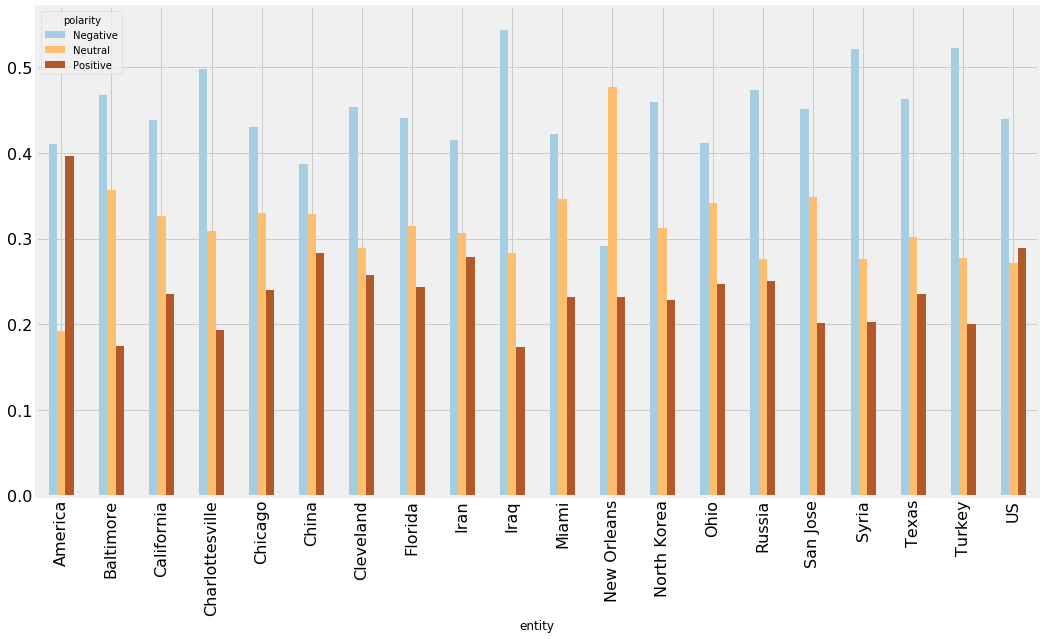

In [21]:
top20people_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20people))])
top20people_polarity = (top20people_polarity.entities.apply(pd.Series)
                        .merge(top20people_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20people_polarity = (top20people_polarity.loc[top20people_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20people))])
top20people_polarity = top20people_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
top20people_polarity.plot(kind = 'bar', figsize=(16,9), colormap='Set1', fontsize=16);
#top20people_polarity

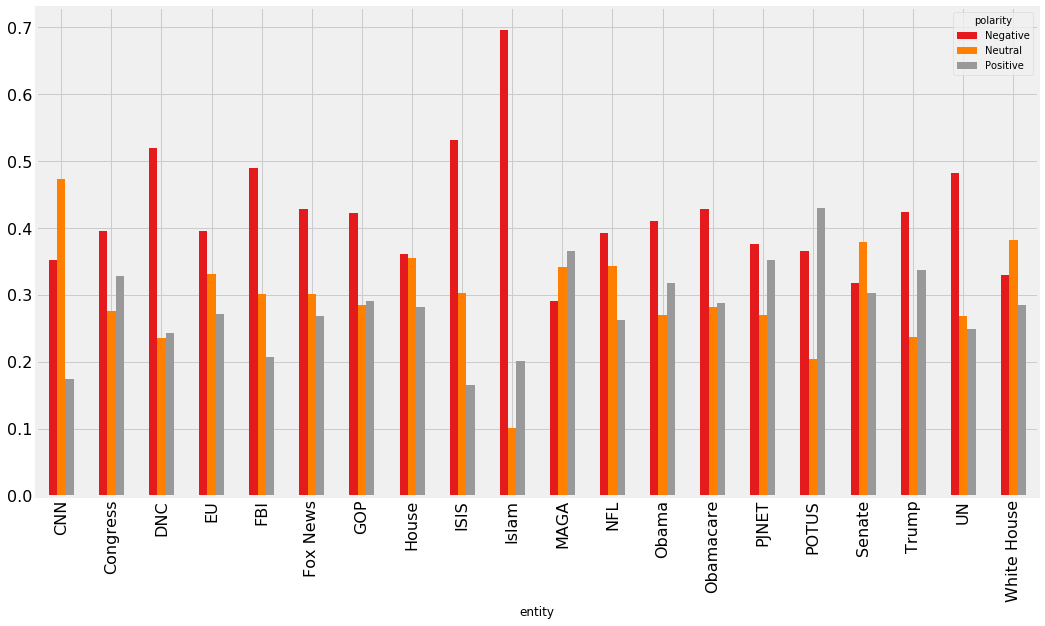

In [26]:
top20org_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20org))])
top20org_polarity = (top20org_polarity.entities.apply(pd.Series)
                        .merge(top20org_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20org_polarity = (top20org_polarity.loc[top20org_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20org))])
top20org_polarity = top20org_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
top20org_polarity.plot(kind = 'bar', figsize=(16,9), colormap='Set1', fontsize=16);
#top20people_polarity

In [23]:
subset.to_csv('../data/eng_tweets_with_entities.csv')